# Plan
- Get line by using cv2 to detect lines and connections between nodes
- nodes will always be in the same locations, ROI will not change
- Find contours is too complex to use, need to simplify to reduce room of errors

In [30]:
import cv2 as cv
import matplotlib.pyplot as plt
from utils import preprocess
from statistics import mean

In [31]:
def canny(img, th_1=50, th_2=200):
    img_canny = cv.Canny(img, th_1, th_2)

    return img_canny

def blur_and_canny(img):
    blurred = cv.GaussianBlur(img, (7,7), 1)
    canny = cv.Canny(blurred, 120, 255, 1)

    return canny

def crop_image(img: cv.Mat) -> cv.Mat:
    height, width = img.shape

    min_height = int(0.3*height)
    max_height = int(0.85*height)
    min_width = int(0.3*width)

    cropped_image = img[min_height:max_height, min_width:width]

    return cropped_image

def resize_image(img: cv.Mat, width=1280, height=720) -> cv.Mat:
    resized = cv.resize(img, (width, height))
    
    return resized

34


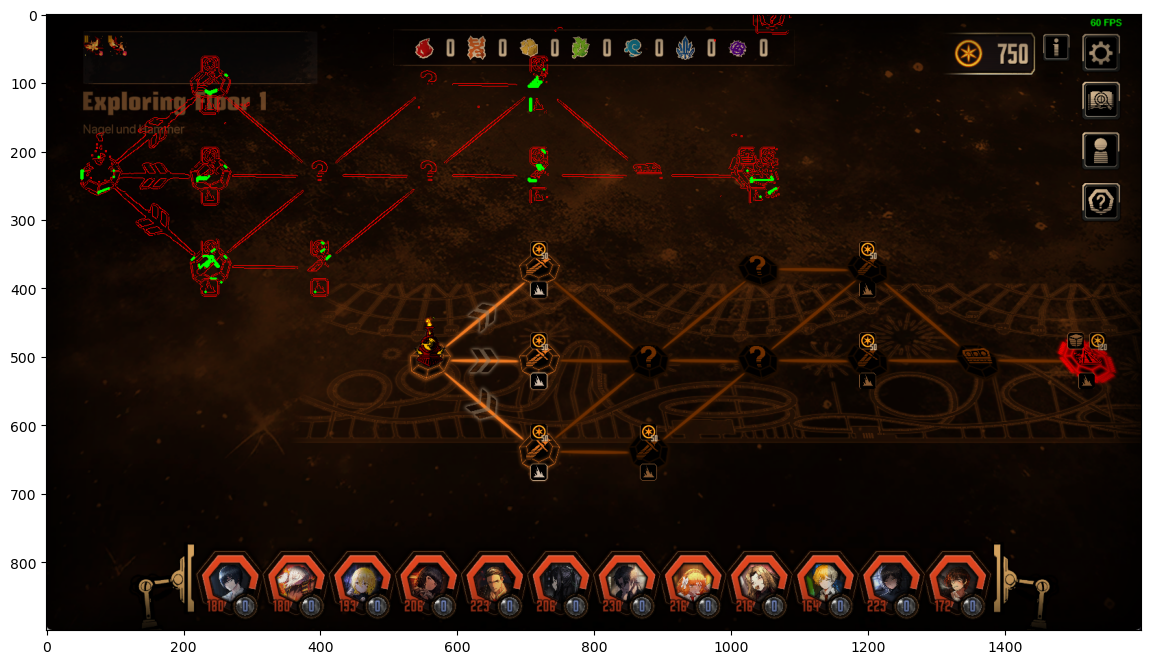

In [32]:
img_original = cv.imread("../images/dungeon2.png")
img_original = cv.cvtColor(img_original, cv.COLOR_BGR2RGB)
img = cv.cvtColor(img_original, cv.COLOR_RGB2GRAY)

img = crop_image(img)
img = preprocess.blur(img, (1,1))
ret, img = cv.threshold(img, 55, 255, cv.THRESH_BINARY)
img = canny(img)
contours, hierarchy = cv.findContours(img, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)

cv.drawContours(img_original, contours, -1, (255,0,0), 1)
approxes = []
for i, cnt in enumerate(contours):
    epsilon = 0.05*cv.arcLength(cnt,True)
    approx = cv.approxPolyDP(cnt,epsilon,True)
    if len(approx) == 3:
        approxes.append(cnt)
        cv.drawContours(img_original, [cnt], 0, (0,255,0), 2)
print(len(approxes))

plt.figure(figsize=(16, 8))
plt.imshow(img_original)

In [33]:
from dataclasses import dataclass

@dataclass
class Nodes():
    x_start: int = 700
    y_start: int = 380
    width: int = 60
    height: int = 60
    x_stride: int = 160
    y_stride: int = 130

@dataclass
class Node():
    name: str
    x: int 
    y: int 
    width: int 
    height: int 
    connection: list["Node"]



In [34]:
x_start = 690
y_start = 370

width = 80
height = 80

x_stride = 160
y_stride = 130

param = Nodes()

nodes = []
index = 1
for i in range(4):
    for j in range(3):
        name = f"Node_{index}"
        node = Node(name, x_start, y_start, width, height, connection=[])
        nodes.append(node)

        y_start = y_start + y_stride
        index = index + 1
    y_start = 370
    x_start = x_start + x_stride

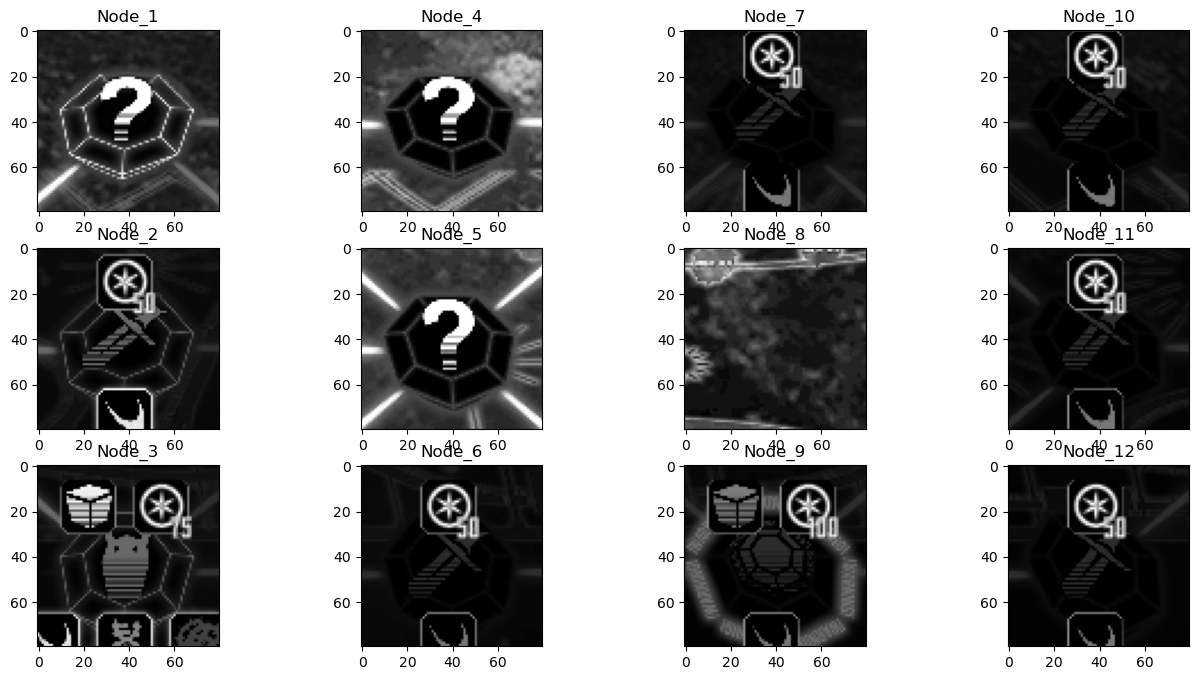

In [35]:
img_original = cv.imread("../images/train_1.png")
img_original = cv.cvtColor(img_original, cv.COLOR_BGR2RGB)
# img = img_original
img = cv.cvtColor(img_original, cv.COLOR_RGB2GRAY)

# img = cv.add(img, 50)
# img = preprocess.blur(img, (3,3))
# ret, img = cv.threshold(img, 55, 255, cv.THRESH_BINARY)
# img = canny(img)

fig, axes = plt.subplots(3, 4, figsize=(16,8))
index = 0
for i in range(4):
    for j in range(3):
        node = nodes[index]
        axes[j,i].set_title(node.name)
        axes[j,i].imshow(img[node.y:node.y+node.height, node.x:node.x+node.width], cmap='gray')
        index = index + 1
        
plt.show()

In [ ]:
from feature_detection import detect_feature, match_feature
import os

dir = "D:\Repository\python-limbus\images\encounter"
queries = []
predictions = []
for file in os.listdir(dir):
    q = cv.imread(f"{dir}\\{file}", cv.IMREAD_GRAYSCALE)
    kp, desc = detect_feature(q, edge_threshold=10)
    query = {
        "name": file.split(".")[0],
        "img": q,
        "keypoints": kp,
        "descriptor": desc
    }
    queries.append(query)

for i, node in enumerate(nodes):
    node_location = img[node.y:node.y+node.height, node.x:node.x+node.width]
    kp, desc = detect_feature(node_location, edge_threshold=10)
    print(i+1)

    if desc is None: 
        continue
    
    pred = {"name":"", "min":0}
    for query in queries:
        matches = match_feature(query["descriptor"], desc, True)
        top_ten = [match.distance for match in matches[:10]]

        if pred["min"] == 0:
            pred["name"] = query["name"]
            pred["min"] = mean(top_ten)
        elif pred["min"] > mean(top_ten):
            pred["name"] = query["name"]
            pred["min"] = mean(top_ten)

    print(pred["name"])



1
event
2
regular
3
focused
4
event
5
event
6
regular
7
regular
8
9
elite
10
regular
11
regular
12
regular


39.666666666666664


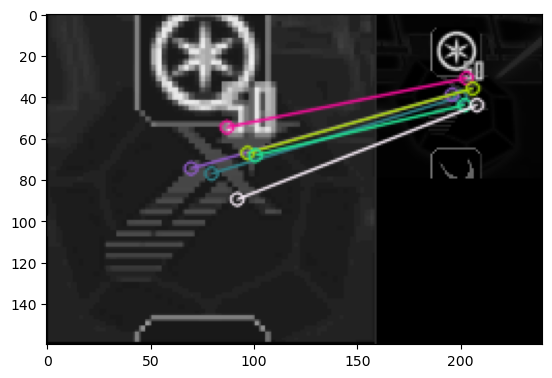

In [37]:
img1 = queries[3]

node = nodes[-1]
img2 = img[node.y:node.y+node.height, node.x:node.x+node.width]
kp2, desc2 = detect_feature(img2)

matches = match_feature(img1["descriptor"], desc2, True)
print(mean([match.distance for match in matches[:10]]))
img_match = cv.drawMatches(img1["img"], img1["keypoints"], img2, kp2, matches[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img_match)
plt.show()

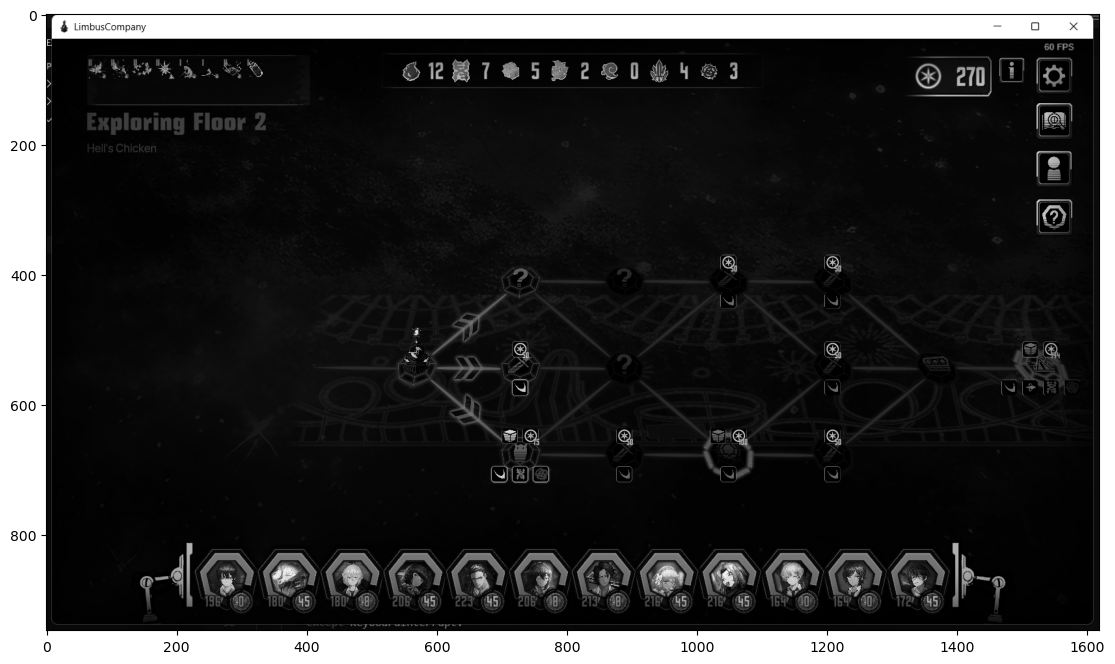

In [38]:
img_original = cv.imread("../images/train_1.png")
img_original = cv.cvtColor(img_original, cv.COLOR_BGR2RGB)
img = cv.cvtColor(img_original, cv.COLOR_RGB2GRAY)

plt.figure(figsize=(16, 8))
plt.imshow(img, cmap='gray')

In [1]:
from limbus.data import Encounters, Config
from limbus.dungeon import Dungeon
import cv2 as cv

dir = "D:\Repository\python-limbus\images\encounter"
dungeon_map = "D:\Repository\python-limbus\images\\train_1.png"

cfg = Config()
md = Dungeon(config=cfg, encounters_dir=dir)
map = cv.imread(dungeon_map, cv.IMREAD_GRAYSCALE)
foo = md.map(map)

for n in foo:
    if n.type < 0:
        continue
    print(n.name, Encounters(n.type).name)

Node_1 EVENT
Node_2 REGULAR
Node_3 FOCUSED
Node_4 EVENT
Node_5 EVENT
Node_6 REGULAR
Node_7 REGULAR
Node_9 ELITE
Node_10 REGULAR
Node_11 REGULAR
Node_12 REGULAR
